# Begin the analysis
Let's first do some exploratory analysis of the data and see what can be used and what needs to be modified

First let's see what we can eliminate in a first approach because it doesn't look like it could be a relevant factor.
* The "Name" column probably doesn't help and cannot anyway be changed into a numerical value easily
* The "Ticket" column doesn't help either

Now let's see what needs to be modified.
* The "Pclass" column needs to be changed into 3 column (Upper, middle and lower) and a binary value should be inside these. That will be way easier to train a model on this.
* The "Sex" column needs to be changed into a binary value as well (1 for female and 0 for male). 
* The "Age" column should be normalized by dividing each value by the age of the oldest person on board. This way we will have a value between 0 and 1 that can be fed to a model
* Sibsp and Parch needs to be normalized as well. We don't know what the effect is of having siblings or parent onboard (maybe they helped each other to escape) so we have to take it into account.
* Fare needs to be normalized
* At first, let's just do a distinction between people who have a cabin (1) and people who don't (0). Then maybe later we can refine the analysis by looking at the type of cabin they have.
* The column "Embarked" needs to be changed into 3 columns C,S,Q and each of them should be binary. Maybe people who embarked from each harbor where closer together and helped each other more.

Okay ! Now we know what to do, so let's start !

### Importing the data and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

df_train = pd.read_csv("train.csv")
df_train.set_index("PassengerId", inplace = True) # Let's set passenger ID as index
df_train.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

### Cleaning the data

In [2]:
# Let's put all the data cleaning inside a function, so it can be reused for the test set.

def clean_data(df):
    # Let's remove the column Name and Ticket
    df.drop(["Name","Ticket"], axis =1, inplace = True)

    # Let's change the Sex and Cabin columns into binary columns (1 for female and 0 for male ; 1 for cabin, 0 for no cabin)
    df['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    df['Cabin'] = df['Cabin'].fillna(0)
    df.loc[df.Cabin != 0, "Cabin"] = 1

    # Let's categorise the columns Pclass and Embarked
    new_Pclass = pd.get_dummies(df["Pclass"],prefix = 'class_') 
    new_Embarked = pd.get_dummies(df["Embarked"],prefix = 'Embarked_')

    df = pd.concat((new_Embarked,df),axis = 1)
    df = pd.concat((new_Pclass, df), axis=1)
    df.drop(["Pclass","Embarked"], axis=1,  inplace = True)
    
    # Now let's normalize the last columns : Age, SibSp, Parch and Fare. 
    # To do this we are going to use the very convenient sklearn package preprocessing.
    columns = list(df.columns) #Let's store the names of our columns

    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = columns
    df.fillna(df.mean(),inplace = True)
    
    return df

In [3]:
# Let's apply to function to our train dataset and see the result
df_train = clean_data(df_train)
df_train.head()

class__1  class__2  class__3  Embarked__C  Embarked__Q  Embarked__S  \
0       0.0       0.0       1.0          0.0          0.0          1.0   
1       1.0       0.0       0.0          1.0          0.0          0.0   
2       0.0       0.0       1.0          0.0          0.0          1.0   
3       1.0       0.0       0.0          0.0          0.0          1.0   
4       0.0       0.0       1.0          0.0          0.0          1.0   

   Survived  Sex       Age  SibSp  Parch      Fare  Cabin  
0       0.0  0.0  0.271174  0.125    0.0  0.014151    0.0  
1       1.0  1.0  0.472229  0.125    0.0  0.139136    1.0  
2       1.0  1.0  0.321438  0.000    0.0  0.015469    0.0  
3       1.0  1.0  0.434531  0.125    0.0  0.103644    1.0  
4       0.0  0.0  0.434531  0.000    0.0  0.015713    0.0

We know have a clean training data set. We can now use it to train our model.
# Machine Learning

In [4]:
# Let's create our features
Feature = df_train[list(df_train.columns)]
Feature.drop(['Survived'], axis = 1,inplace=True)
X_train = Feature
y_train = df_train['Survived'].values

### Let's first try a KNN model

Train set: (712, 12) (712,)
Test set: (179, 12) (179,)


(0.75, 0.85)

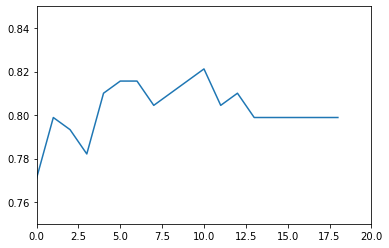

In [5]:
# We don't know what the best K might be so let's find it first
# To do this we need to explore a bit 
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print ('Train set:', X_train_t.shape,  y_train_t.shape)
print ('Test set:', X_test_t.shape,  y_test_t.shape)

Ks=20
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train_t,y_train_t)
    yhat = kNN_model.predict(X_test_t)
    
    mean_acc[n-1]=np.mean(yhat==y_test_t);
    
    std_acc[n-1]=np.std(yhat==y_test_t)/np.sqrt(yhat.shape[0])

# Let's display our finding and find the best K
plt.plot(mean_acc)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(0, 20)
plt.ylim(0.75, 0.85)

We can see that the top of the graph is for X = 10, but in python arrays count from 0 so it means we want to have 11 K clusers.

In [6]:
k = 11
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(n_neighbors=11)

We now have a trained model that on which we can apply our test data set. When we publish the result on Kaggle we can see what our accuracy is.

## Importing and cleaning the test data set

In [9]:
df_test = pd.read_csv("test.csv")
passenger_id = df_test["PassengerId"] # Let's store our passenger IDs for later before putting them as indexes
df_test.set_index("PassengerId", inplace = True)

In [10]:
df_test = clean_data(df_test)
df_test.head()

class__1  class__2  class__3  Embarked__C  Embarked__Q  Embarked__S  Sex  \
0       0.0       0.0       1.0          0.0          1.0          0.0  0.0   
1       0.0       0.0       1.0          0.0          0.0          1.0  1.0   
2       0.0       1.0       0.0          0.0          1.0          0.0  0.0   
3       0.0       0.0       1.0          0.0          0.0          1.0  0.0   
4       0.0       0.0       1.0          0.0          0.0          1.0  1.0   

        Age  SibSp     Parch      Fare  Cabin  
0  0.452723  0.000  0.000000  0.015282    0.0  
1  0.617566  0.125  0.000000  0.013663    0.0  
2  0.815377  0.000  0.000000  0.018909    0.0  
3  0.353818  0.000  0.000000  0.016908    0.0  
4  0.287881  0.125  0.111111  0.023984    0.0

It looks good. We can know predict if a passenger was likely to survive or not using our model.

In [12]:
Feature = df_test[list(df_test.columns)]
X_test = Feature

yhat_knn_final = kNN_model.predict(X_test)
len(yhat_knn_final)

418

In [13]:
# We can now create the submission data frame to publish to Kaggle
df_submission = pd.concat((passenger_id,pd.DataFrame(yhat_knn_final,columns = ["Survived"])),axis = 1)
df_submission = df_submission.astype(int)
df_submission

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

In [16]:
#Let's export the file
df_submission.to_csv(r'C:\Users\pierr\OneDrive\Bureau\Coding\ADF\Kaggle competitions\titanic\Titanic_submission.csv', index = False)

Submit prediction with Kaggle API : **kaggle competitions submit -c titanic -f Titanic_submission.csv -m "Message"**

We obtain a score of **0.77033**. This is pretty good, considering that this is not something that can be entirely predicted. 